In [1]:
# https://towardsdatascience.com/lstm-time-series-forecasting-predicting-stock-prices-using-an-lstm-model-6223e9644a2f
# Multi-Step LSTM Time Series Forecasting Models: https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

In [2]:
import os
import boto3
import json
import re
import pandas as pd
import numpy as np
import keras
import math
import matplotlib.pyplot as plt
from datetime import datetime
from keras.models import Sequential
from keras.layers import (Dense, LSTM, Dropout)
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (mean_squared_error, mean_absolute_error)
from sklearn.model_selection import train_test_split

## Fetch & Clean data

In [3]:
# define client, folder and files for AWS.
s3_client = boto3.client("s3")
s3_bucket_name = 'thesis-hydroponic-project'
s3_bucket_prefix = 'TemperatureAndHumidity2021/'

In [4]:
# Fetch existing data or load fresh data.
# Remove redundancy and null.
files = s3_client.list_objects(Bucket=s3_bucket_name, Prefix=s3_bucket_prefix)['Contents']
parsed_sensor_values = []
for file in files:
    if not os.path.isfile('.cache/' + file['Key']) or (datetime.now() - datetime.fromtimestamp(os.path.getctime('.cache/' + file['Key']))).days > 31:
        print("Fetching fresh file from S3:", file['Key'])
        s3_object = s3_client.get_object(Bucket=s3_bucket_name, Key= file['Key'])
        raw_sensor_values = s3_object['Body'].read().decode()
        clean_sensor_values = re.sub(",+", ",", raw_sensor_values)
        sensor_values = json.loads("[" + clean_sensor_values.strip(',') + "]")
    else:
        print("Load from cache:", file['Key'])
        with open('.cache/' + file['Key']) as f:
            sensor_values = json.load(f)
    parsed_sensor_values += sensor_values
    os.makedirs('.cache/' + os.path.dirname(file['Key']), exist_ok=True)
    with open('.cache/' + file['Key'], 'w') as f:
        json.dump(sensor_values, f)

549cf-c5ae-449b-8876-ea33f1369d9f
Load from cache: TemperatureAndHumidity2021/03/07/10/ThesisHydroponicSensorDeliveryStream-1-2021-03-07-10-35-12-c5f541a0-3ff9-47f4-91b2-8f1aded1cae4
Load from cache: TemperatureAndHumidity2021/03/07/10/ThesisHydroponicSensorDeliveryStream-1-2021-03-07-10-50-15-942453d3-bfbd-424c-b535-b66b10f1cd3f
Load from cache: TemperatureAndHumidity2021/03/07/11/ThesisHydroponicSensorDeliveryStream-1-2021-03-07-11-05-22-f4432023-5fe6-4f93-9f13-3647bcd6a2f1
Load from cache: TemperatureAndHumidity2021/03/07/11/ThesisHydroponicSensorDeliveryStream-1-2021-03-07-11-20-30-622e0f3b-2f37-4297-80fa-d8054859b1b0
Load from cache: TemperatureAndHumidity2021/03/07/11/ThesisHydroponicSensorDeliveryStream-1-2021-03-07-11-35-38-b7d672e6-05bf-4460-ac67-5a10c6398b83
Load from cache: TemperatureAndHumidity2021/03/07/11/ThesisHydroponicSensorDeliveryStream-1-2021-03-07-11-50-40-a73158b4-e380-45bb-a389-7679688225a2
Load from cache: TemperatureAndHumidity2021/03/07/12/ThesisHydroponicSen

## Data preparation

In [5]:
df = pd.DataFrame(parsed_sensor_values)

In [6]:
df['temperature'] = df['temperature'].astype(float)
df['humidity'] = df['humidity'].astype(float)
df['datetime'] = pd.to_datetime(df['datetime'])

In [7]:
df.sort_values('datetime', ascending=True, inplace=True)

In [8]:
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (16059, 4)


,sensor_type,temperature,humidity,datetime
0,hydroponic sensor,14.0,38.0,2021-02-26 08:51:37
1,hydroponic sensor,15.0,36.0,2021-02-26 08:51:43
2,hydroponic sensor,15.0,36.0,2021-02-26 08:51:48
3,hydroponic sensor,15.0,36.0,2021-02-26 08:51:53
4,hydroponic sensor,15.0,35.0,2021-02-26 08:51:58


In [9]:
# Splitting dataset into trainning and testing sets.
split_index = int(len(df) * 0.7)
training_set = df.iloc[:split_index, 1:2].values
test_set = df.iloc[split_index:, 1:2].values

In [10]:
print('Number of rows and columns in training dataset:', training_set.shape)
print('Number of rows and columns in testing dataset:', test_set.shape)

Number of rows and columns in training dataset: (11241, 1)
Number of rows and columns in testing dataset: (4818, 1)


In [11]:
# Feature Scaling.
sc = MinMaxScaler(feature_range = (0,1))
training_set_scaled = sc.fit_transform(training_set)

In [12]:
# Creating a data structure with 60 time-steps and 1 output.
X_train = []
y_train = []
# n_time_steps = 60
n_time_steps = 10
for i in range(n_time_steps, len(training_set)):
    start_index = i-n_time_steps
    X_train.append(training_set_scaled[start_index:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Preparing for modeling by setting number of feature dimension.
n_features = 1
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))
print('Number of rows and columns in X_train:', X_train.shape)

Number of rows and columns in X_train: (11231, 10, 1)


## Train Model

In [13]:
# Build the LSTM Model with 50 neurons and 4 hidden layers.
# Assign 1 neuron in the output layer for predicting the normalized temperature value.
# Use the MSE loss function and the Adam stochastic gradient descent optimizer.
# We use Dropout to avoid overfitting
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Fitting the RNN to the Training set
# weights only are updated when a batch is completed
model.fit(X_train, y_train, epochs = 2, batch_size = 30)

Epoch 1/2
375/375 [==============================] - 5s 14ms/step - loss: 0.0244
Epoch 2/2
375/375 [==============================] - 5s 13ms/step - loss: 0.0084


In [14]:
# Prepare the test data (reshape them)
# Getting the predicted temperature.
dataset_train = df.iloc[:len(training_set), 1:2]
dataset_test = df.iloc[len(training_set):, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
n_inputs = len(dataset_total) - len(dataset_test) - n_time_steps
print(n_inputs)
inputs = dataset_total[n_inputs:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

# Preparing testing dataset.
X_test = []
for i in range(n_time_steps, len(inputs)):
    X_test.append(inputs[i-n_time_steps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

11231


In [15]:
predicted_temperature = model.predict(X_test)
predicted_temperature = sc.inverse_transform(predicted_temperature)

## Evaluate Model

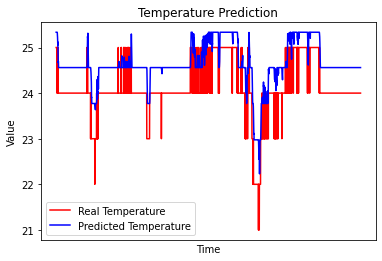

In [16]:
# Visualising the results
plt.plot(df.loc[len(training_set):, 'datetime'],dataset_test.values, color = 'red', label = 'Real Temperature')
plt.plot(df.loc[len(training_set):, 'datetime'],predicted_temperature, color = 'blue', label = 'Predicted Temperature')
plt.xticks(np.arange(0,4818, 5000))
plt.title('Temperature Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()